# extract arome wind data and store

10 m/s = ?? Pa = BF = 5BF = 36 km/h = 19 knts

In [1]:
import os
from glob import glob

%matplotlib inline
import matplotlib.pyplot as plt
import cmocean.cm as cm
import cartopy.crs as ccrs

import numpy as np
import pandas as pd
import xarray as xr

----

## wind, arome

To be done on datarmor.
Copy extracted netcdf file back on laptop.


In [3]:
arome_dir = "/home/ref-oc-intranet-restricted/modeles_mf/arome_v2/best_estimate/"


def load_arome(t, dt=None, freq="1H", rkwargs={}, **kwargs):
    """Extract ERA data
    https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5

    Parameters
    ----------
    t: date-like object, list
        date for extraction, [tstart, tend]
    dt: tuple, optional
        time interval in days around t
    freq: str
        frequency of outputs selected, e.g. "1H" or "1D"
    rkwargs: dict
        passed to load_dataset
    **kwargs: passed for direct selection
    """

    if not isinstance(t, list):
        t = [t, t]
    # t = [pd.to_datetime(_t) for _t in t]

    if dt is not None:
        t = [t[0] + pd.Timedelta(days=dt[0]), t[-1] + pd.Timedelta(days=dt[1])]
        t = pd.date_range(t[0], t[-1], freq=freq)
    else:
        t = [t]

    #
    D = []
    for _t in t:
        _rpath = f"{_t.year}/METEOFRANCE_AROME_{_t.year}{_t.month:02d}{_t.day:02d}T{_t.hour:02d}Z*.nc"
        files = glob(os.path.join(arome_dir, _rpath))
        _ds = xr.merge(
            [xr.load_dataset(f, **rkwargs).squeeze().sel(**kwargs) for f in files]
        )
        D.append(_ds)
    ds = xr.concat(D, dim="time")

    return ds

In [4]:
dt = (-5, 5)

#
deployment = "drixmed22"

start = pd.Timestamp(2022, 9, 20)
end = pd.Timestamp(2022, 9, 25)
lon = slice(4.55, 6.1)
lat = slice(42.75, 43.45)

ds = load_arome([start, end], dt=dt, longitude=lon, latitude=lat).chunk(
    dict(time="auto")
)

nc = os.path.join(os.getenv("SCRATCH"), deployment + "_arome.nc")
ds.to_netcdf(nc, mode="w")

print(f"{nc} written")

/home1/scratch/aponte/drixmed22_arome.nc written


### quick overview

In [5]:
ds = xr.open_dataset("/home1/scratch/aponte/drixmed22_arome.nc")
ds

<xarray.Dataset>
Dimensions:    (time: 361, latitude: 28, longitude: 63)
Coordinates:
  * time       (time) datetime64[ns] 2022-09-15 ... 2022-09-30
  * latitude   (latitude) float32 42.75 42.78 42.8 42.83 ... 43.38 43.4 43.42
  * longitude  (longitude) float32 4.55 4.575 4.6 4.625 ... 6.025 6.05 6.075 6.1
    height     float32 ...
Data variables: (12/13)
    hu2m       (time, latitude, longitude) float32 ...
    nebul      (time, latitude, longitude) float32 ...
    pmer       (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    u10m       (time, latitude, longitude) float32 ...
    v10m       (time, latitude, longitude) float32 ...
    ...         ...
    flsen      (time, latitude, longitude) float32 ...
    flsolaire  (time, latitude, longitude) float32 ...
    fltherm    (time, latitude, longitude) float32 ...
    ustress    (time, latitude, longitude) float32 ...
    vstress    (time, latitude, longitude) float32 ...
    eau        (time, latitude, longitude) float32 ...
Attributes: (12/40)
    data_type:               OCO straight grid
    format_version:          1.2
    title:                   Meteo-France Arome analysis and forecast
    Conventions:             CF-1.3
    netcdf_version:          3.5
    product_name:            METEOFRANCE_AROME_20220915T00Z.nc
    ...                      ...
    data_centre:             CD-OCO
    data_centre_references:  http://www.previmer.org/
    contact:                 cdoco-exploit@ifremer.fr
    distribution_statement:  Data restrictions: for registered users only
    operational_status:      operational
    quality_index:           1

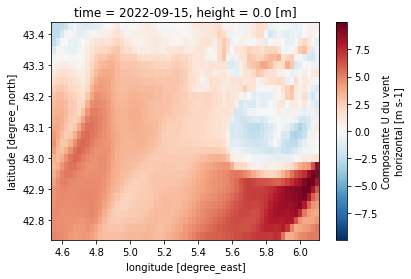

In [7]:
ds.isel(time=0).u10m.plot()

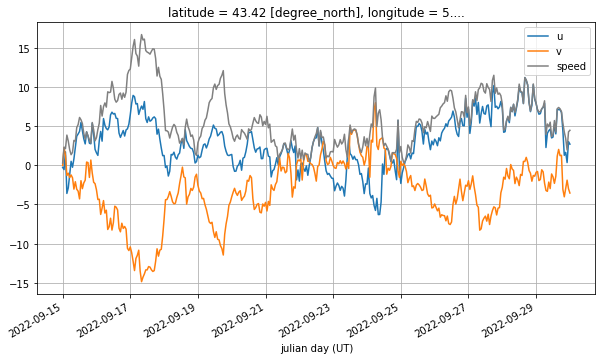

In [9]:
_ds = ds.sel(longitude=5.2, latitude=43.5, method="nearest")

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
_ds.u10m.plot(label="u")
_ds.v10m.plot(label="v")
np.sqrt(_ds.u10m**2 + _ds.v10m**2).plot(label="speed", color="0.5")

ax.grid()
ax.set_ylabel("")
ax.legend()

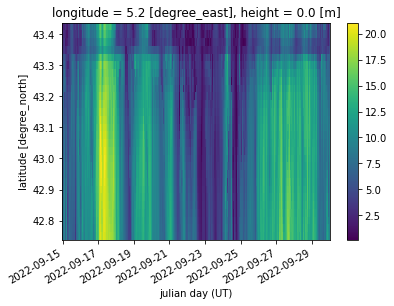

In [14]:
_ds = ds.sel(longitude=5.2)
np.sqrt(_ds.u10m**2 + _ds.v10m**2).plot(x="time")

In [8]:
deployment = "2019_summer_toulon"

# define points of interest
lonp = [5.904, 5.904]
latp = [43.045, 42.9]
labels = ["nearshore", "offshore"]


# load info
dinfo = deployments[deployment]
raw_data_dir = hy.raw_dir(deployment)
processed_data_dir = hy.processed_dir(deployment)

# load arome data
ds = xr.open_dataset(os.path.join(processed_data_dir, "wind_arome.nc"))

dsp = xr.Dataset(dict(lon=("point", lonp), lat=("point", latp)))
dsp = ds.interp(longitude=dsp.lon, latitude=dsp.lat).assign_coords(
    point=("point", labels)
)
dsp["speed10m"] = np.sqrt(dsp.u10m**2 + dsp.v10m**2)
dsp["stress"] = np.sqrt(dsp.ustress**2 + dsp.vstress**2)
dsp

<xarray.Dataset>
Dimensions:    (time: 457, point: 2)
Coordinates:
  * time       (time) datetime64[ns] 2019-06-13 ... 2019-07-02
    height     float32 0.0
    longitude  (point) float64 5.904 5.904
    latitude   (point) float64 43.05 42.9
  * point      (point) <U9 'nearshore' 'offshore'
Data variables: (12/15)
    hu2m       (time, point) float64 0.6882 0.6483 0.768 ... 0.9541 0.8661 0.941
    nebul      (time, point) float64 0.0 0.0 0.0 0.0 ... 0.9815 0.4741 1.0 1.0
    pmer       (time, point) float64 1.015e+05 1.015e+05 ... 1.016e+05 1.017e+05
    t2m        (time, point) float64 290.4 290.9 288.1 ... 295.8 296.6 296.3
    u10m       (time, point) float64 5.17 6.94 4.45 4.602 ... 3.382 1.54 2.751
    v10m       (time, point) float64 -2.04 -2.914 -2.559 ... 0.7335 -0.8474
    ...         ...
    fltherm    (time, point) float64 -4.063e+05 -4.184e+05 ... -2.808e+05
    ustress    (time, point) float64 -141.0 -260.5 -145.7 ... -25.57 -66.44
    vstress    (time, point) float64 57.67 89.37 74.84 ... -6.377 -1.106 22.39
    eau        (time, point) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    speed10m   (time, point) float64 5.558 7.527 5.134 ... 3.409 1.706 2.879
    stress     (time, point) float64 152.4 275.4 163.8 ... 57.46 25.6 70.12
Attributes: (12/40)
    data_type:               OCO straight grid
    format_version:          1.2
    title:                   Meteo-France Arome analysis and forecast
    Conventions:             CF-1.3
    netcdf_version:          3.5
    product_name:            METEOFRANCE_AROME_20190613T00Z.nc
    ...                      ...
    data_centre:             CD-OCO
    data_centre_references:  http://www.previmer.org/
    contact:                 cdoco-exploit@ifremer.fr
    distribution_statement:  Data restrictions: for registered users only
    operational_status:      operational
    quality_index:           1

### map with point locations

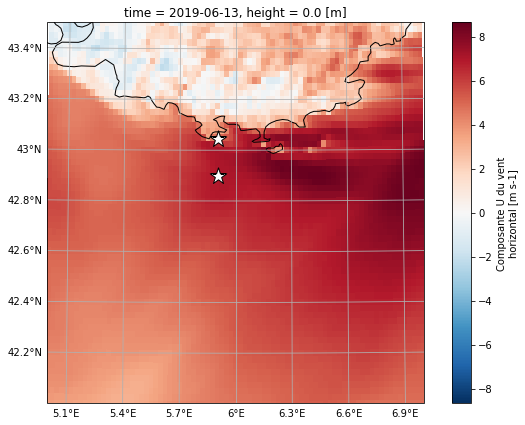

In [9]:
_ds = ds.isel(time=0)
fig, ax = plot_map(_ds.u10m)

ax.scatter(
    x=dsp.longitude,
    y=dsp.latitude,
    s=300,
    facecolor="w",
    edgecolor="k",
    marker="*",
    transform=ccrs.PlateCarree(),
)

### time series

In [11]:
dinfo

{'start': Timestamp('2019-07-13 00:00:00'),
 'end': Timestamp('2019-07-31 00:00:00'),
 'site': 'toulon'}

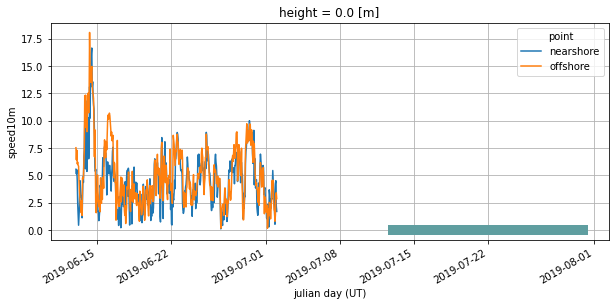

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
dsp.speed10m.plot.line(x="time")
ax.plot([dinfo["start"], dinfo["end"]], [0, 0], lw=10, color="cadetblue")
ax.grid()

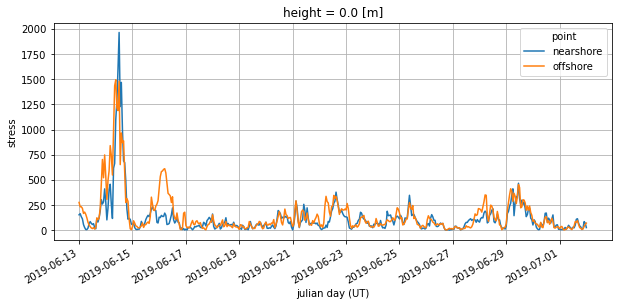

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
dsp.stress.plot.line(x="time")
ax.grid()

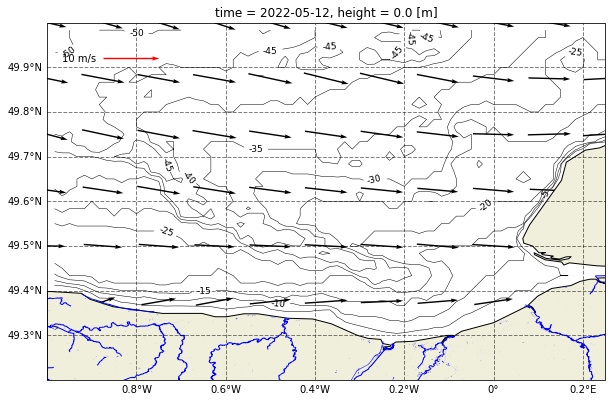

In [42]:
bounds = [-0.5, -0.1, 49.25, 49.5]
bounds = [-1.0, 0.25, 49.2, 50.0]
fig, ax, crs = cp.plot_map(bounds=bounds, coast="bseine", land=None, rivers="bseine")

di = 5
_ds = ds.sel(time="2022-05-12 00:00:00").isel(
    longitude=slice(0, None, di), latitude=slice(0, None, di)
)

q = _ds.plot.quiver(
    x="longitude", y="latitude", u="u10m", v="v10m", scale=1e2, transform=crs, zorder=-2
)
qk = ax.quiverkey(
    q,
    0.1,
    0.9,
    10,
    "10 m/s",
    transform=crs,
    color="r",
    labelpos="W",
    coordinates="axes",
    zorder=10,
)